# Modeling the Detectability of a Population of Transients

A common LSST science case is to detect a large sample of some family of transient objects for further study.  A good proxy for a scientific Figure of Merit in this case is the sample size or fraction of objects detected.  In this tutorial, we will define a simple example model lightcurve, and then use MAF to quantify the detectability of a sample of such objects.

## Requirements
You will need to have MAF installed. See [here](https://confluence.lsstcorp.org/display/SIM/Catalogs+and+MAF) for instructions.

## Preliminaries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.utils import equatorialFromGalactic
# Make the notebook repeatable
np.random.seed(42)

## Defining the Transient Object and Detectability Metric

First we need a function to generate a lightcurve that takes as input the times the lightcurve is observed, and then parameters that descibe the shape of the lightcurve.

In [2]:
def toyObjectLC(t, t0, peak, slope, duration=10.):
    """
    Makes a transient object lightcurve that has an instantaneous appearance followed by a 
    linear rise or decline and then an instantaneous disappearance.

    Parameters
    ----------
    t : np.array
        Array of observation times (days)
    t0 : float
        The peak time (days)
    peak : float
        Peak brightness (mags)
    slope : float
        Slope of the lightcurve (mags/day). Negative values of b result in 
        a brightening object
    duration : float (10)
        Time between appearance and disappearance (days)
        
    Returns
    -------
    lightcurve : np.array
        1-D array of magnitudes to match t
        
    Notes
    -----
    Objects could be given colors by setting different parameters per filter; for now 
    this is assumed to be a flat SED source. If you do extend this to include filter 
    information, don't forget that you may be restricted by the bands that you select in 
    your SQL query.     
    """
    # Make an array of magnitudes to match input times
    lightcurve = np.zeros(np.size(t), dtype=float) + 99.
    # Select only times in the lightcurve duration window
    good = np.where( (t >= t0) & (t <= t0+duration) )
    lightcurve[good] = peak + slope*(t[good]-t0)
    return lightcurve


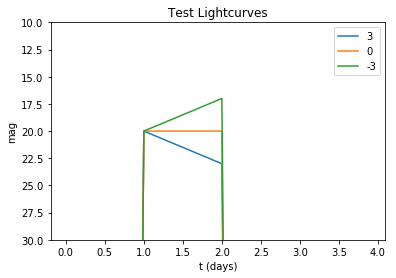

In [3]:
# Check that the lightcurves look correct
t = np.arange(0,4,.1)
t0 = 1.
duration = 1.
peak = 20
slopes = [3, 0, -3]
for slope in slopes:
    lc = toyObjectLC(t, t0, peak, slope, duration=duration)
    plt.plot(t, lc, label='%i' % slope)
plt.xlabel('t (days)')
plt.ylabel('mag')
# Always plot magnitudes backwards
plt.ylim([30,10])
plt.legend()
plt.title('Test Lightcurves')

Now we need a metric that can quantify the degree to which a lightcurve has been "well observed". For this example, we will say that any lightcurve that is observed to be above the 5-sigma limiting depth twice in any filter is "well-observed".

In [4]:
class ToyDetectabilityMetric(metrics.BaseMetric):
    """
    Quantifies detectability of toyObjects.
    
    Parameters
    ----------
    ptsNeeded : int
        Number of an object's lightcurve points required to be above the 5-sigma limiting depth 
        before it is considered detected.
    
    Notes
    -----
    This metric assumes this will be run with a slicer that has had extra 
    parameters (t0, peak, and slope) added to the slicer.slicePoint 
    dict (which already contains ra, dec, fieldID, etc). All the observation information 
    (MJD of observation, 5-sigma limiting depth of each observation, etc) is contained in the
    dataSlice array. We request the filter information for each observation anticipating that
    more general lightcurve functions will need it as input.
    """
    def __init__(self, metricName='ToyDetectabilityMetric', mjdCol='expMJD', m5Col='fiveSigmaDepth',
                 filterCol='filter', ptsNeeded=2, **kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.ptsNeeded = ptsNeeded
        super(ToyDetectabilityMetric, self).__init__(col=[self.mjdCol, self.m5Col, 
                                                          self.filterCol],
                                                     units='Detected, 0 or 1',
                                                     metricName=metricName,
                                                     **kwargs)
        
    def run(self,  dataSlice, slicePoint=None):
        # Generate the lightcurve for this object
        lightcurve = toyObjectLC(dataSlice[self.mjdCol], slicePoint['t0'], 
                                 slicePoint['peak'], slicePoint['slope'])
        # Check if there are enough points detected in the generated lightcurve
        npts = np.where( (lightcurve != 0.) & (lightcurve < dataSlice[self.m5Col]))[0].size
        if npts >= self.ptsNeeded:
            return 1
        else:
            return 0

Let's model our population of transient objects so that we can check to see if they are "well observed".  

We will model each object as having a position given by `RA` and `dec`, an explosion time of `t0`, and a simple light curve shape governed by parameters `peak` and `slope`.

In [5]:
# The fields for our transient catalog
names = ['ra', 'dec', 't0', 'peak', 'slope']
# Number of objects to create
nobjs = int(1e3)  #  Note, we are going to loop over each object, so try not to make this a crazy huge number. 
# An empty numpy array that will hold the catalog of transient objects
transObjects = np.zeros(nobjs, dtype=list(zip(names, [float]*len(names))))
# Concentrate objects in the galactic plane
l = np.random.rand(nobjs)*360.
b = np.random.randn(nobjs)*20.
transObjects['ra'], transObjects['dec'] = equatorialFromGalactic(l,b) 
# Generate lightcurve parameters 

# Force our objects to start exploding near the start date of the survey and go for 10 years
# The 59580 value is the start date for the simulation we are using (minion_1016). 
# Older simulations have different start dates... 
transObjects['t0'] = np.random.rand(nobjs) * 365.25 * 10 + 59580.
transObjects['peak'] = np.random.rand(nobjs) * 3 + 20.
transObjects['slope'] = np.random.rand(nobjs) * 1.1

## Setting up MAF

Since we have a catalog with sky positions, we want to check each of those positions. So rather than evaluate our metric on a grid on the sky (e.g., at HEALpixel locations), we will use the `UserPointSlicer` to find the observations that contain each of our transient objects.

We will then connect to a database and bundle our metric, slicer, and sql query in the usual way.

In [6]:
# Set up the slicer to evaluate the catalog we just made
# XXX--ugh, because the old V3 OpSim runs store things in radians, need to set latLonDeg kwarg. 
slicer = slicers.UserPointsSlicer(transObjects['ra'], transObjects['dec'], latLonDeg=False)
# Add any additional information about each object to the slicer
slicer.slicePoints['t0'] = transObjects['t0']
slicer.slicePoints['peak'] = transObjects['peak']
slicer.slicePoints['slope'] = transObjects['slope']

Let's connect to an OpSim database and set the output directory:

In [7]:
runName = 'minion_1016'
opsdb = db.OpsimDatabaseV3(runName + '_sqlite.db')
outDir = 'TransientsUPS'
resultsDb = db.ResultsDb(outDir=outDir)

As well as a metric and a slicer, we also need to define an SQL query. Let's look at the first 5 years of observations, and limit ourselves to the _riz_ filters. Note how plotting labels need to be defined at bundling time.

In [8]:
metric = ToyDetectabilityMetric()
sql = 'night < %i and (filter="r" or filter="i" or filter="z")' % (365.25*5)
plotDict = {'title':'Toy transient detectability', 'xlabel':'Object detected? (0 or 1)'}
plotDict['bins'] = [-0.25, 0.25, 0.75, 1.25]
bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName, plotDict=plotDict)

## Running the Metric

Recall: we often run more than one metric, or SQL-slicer combinations, at a time, so standard procedure is to define groups of bundles and run them all. Let's follow this procedure. 

In [9]:
bundleList = [bundle]
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database Summary with constraint night < 1826 and (filter="r" or filter="i" or filter="z") for columns ['fieldRA', 'fieldDec', 'fiveSigmaDepth', 'filter', 'expMJD']
Found 802608 visits
Running:  ['minion_1016_ToyDetectabilityMetric_night_lt_1826_and_r_or_i_or_z_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "night < 1826 and (filter="r" or filter="i" or filter="z")" constraint now.


/Users/yoachim/gitRepos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:526: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(plotDict['bgcolor'])


Plotting complete.


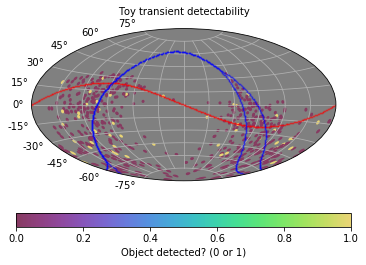

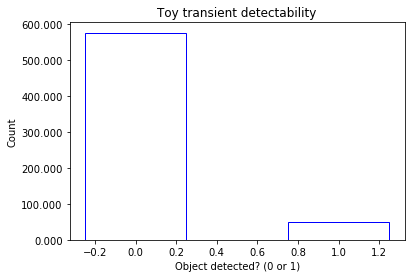

In [10]:
bgroup.plotAll(closefigs=False)

Note a possibly confusing fature in the plots here:  The histogram shows ~600 transients were not detected, and ~50 were. But we input 1,000. The sky map also has no points in the far north.  This is a "feature" of MAF that if a point in the sky has no overlapping observations, that point is masked. Only unmasked points get plotted by default. We can check this explicitly by inspecting the `metricValues`.

In [11]:
# If the metricValue is 1, the object was detected
num = np.where(bundle.metricValues == 1)[0].size
print('Number of detections = %i' % num)

# If the value was zero, and unmasked, that means some observations 
# were taken at that point in the sky
num = np.where((bundle.metricValues == 0) & (bundle.metricValues.mask == False))[0].size
print('Number of non-detections = %i' % num)

# Find the number of transients where LSST took no observations at that spot
num = np.where( (bundle.metricValues == 0) &
               (bundle.metricValues.mask == True))[0].size
print('Number of transients with no overlapping observations at that spot = %i' % num)

Number of detections = 50
Number of non-detections = 576
Number of transients with no overlapping observations at that spot = 0


## Working with MAF Outputs: Detection Fraction Maps

All our metric did was return 0 or 1 for each individual object, according to its detection criteria. To visualize the results of this analysis as a detection map, we need to bin the catalog on the sky. Healpix is a good scheme for doing this, and we can use the `healbin` convience function from the `sims.utils` package. First, we count all the objects in each healpixel, then count all the detected objects in each healpixel.

In [12]:
from lsst.sims.utils import healbin
import healpy as hp
# Set the resolution of the healpix grid - nside=32 corresponds to ~1 degree pixels
nside = 8
allObjects = healbin(transObjects['ra'], transObjects['dec'], np.ones(nobjs), 
                     nside=nside, reduceFunc=np.sum)
detectedObjects = healbin(transObjects['ra'], transObjects['dec'],bundle.metricValues, 
                          nside=nside, reduceFunc=np.sum)

/Users/yoachim/gitRepos/sims_utils/python/lsst/sims/utils/healpyUtils.py:140: UserWarning: Warning: converting a masked element to nan.
  mapVals[idx] = reduceFunc(values[left[i]:right[i]])


We now have some `healpy` arrays, and so can use standard `healpy` plotting methods. Empty healpixels are given value `hp.UNSEEN` by `healbin`, and are plotted in gray.

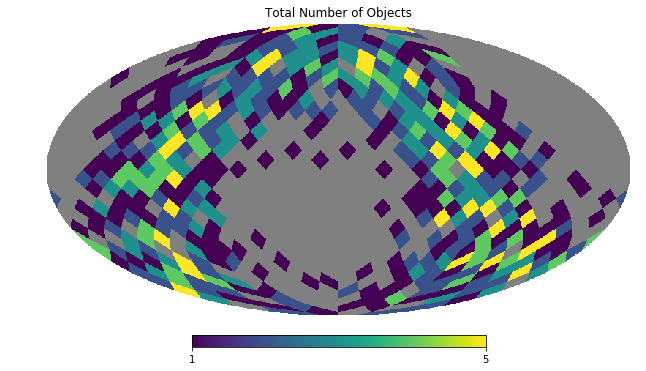

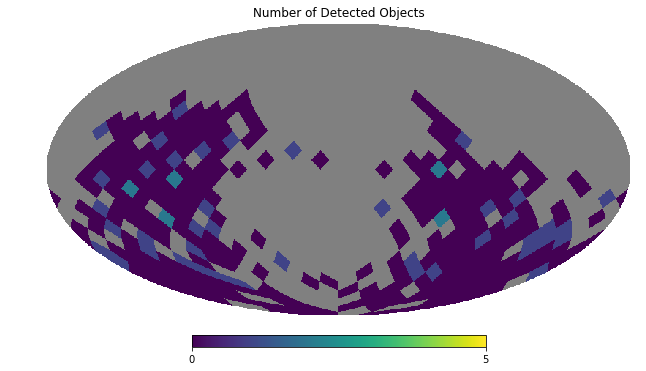

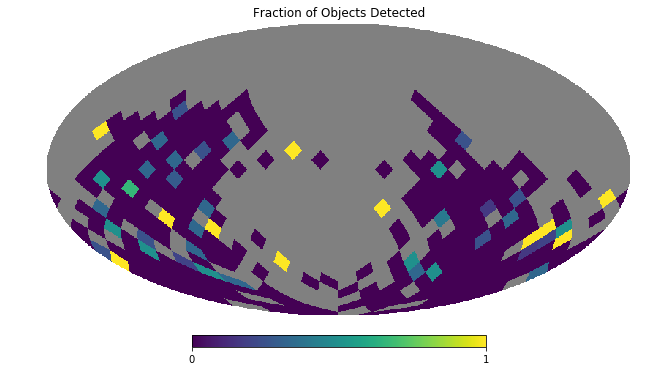

In [13]:
Nmax = 5
hp.mollview(allObjects, title='Total Number of Objects', max=Nmax)
hp.mollview(detectedObjects, title='Number of Detected Objects', max=Nmax)
frac = detectedObjects/allObjects
frac[np.where((allObjects == 0) | (detectedObjects == hp.UNSEEN))] = hp.UNSEEN
hp.mollview(frac, title='Fraction of Objects Detected')

As well as maps, we might want some global summary statistics - to quote as a Figure of Merit, for example. We can do that by operating on the `metricValues` directly - in our case, the fraction of objects detected could be a good proxy for a Figure of Merit. 

In [14]:
print('Fraction of Toy objects detected = %f' % (np.sum(bundle.metricValues)/nobjs))

Fraction of Toy objects detected = 0.050000


## Further Analysis

As Eric Bellm points out, it might be nice to look at how detectability depends on the lightcurve properties. Let's look at how detectability, peak brightness, and slope relate.

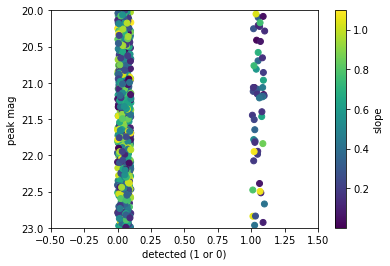

In [15]:
# add a little noise to separate the point on the plot
noise = np.random.rand(bundle.metricValues.size)*.1
plt.scatter(bundle.metricValues + noise, 
            transObjects['peak'], c=transObjects['slope'])
plt.xlabel('detected (1 or 0)')
plt.ylabel('peak mag')
plt.ylim([23,20])
plt.xlim([-.5, 1.5])
cb = plt.colorbar()
cb.set_label('slope')

As we might expect, the sample that was detected shows a faintness cut-off that isn't in the whole population.